In [ ]:
# Customer Data Analysis - Scenario 1: Billing Reconciliation
# This notebook analyzes billing reconciliation for customer disputes

# Import standard libraries
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import os

# Add project root (parent of this notebooks folder) to path to import custom modules
project_root = Path('.').resolve().parent
sys.path.insert(0, str(project_root))

# Ensure current working directory is the project root so relative data paths work
os.chdir(project_root)

# Import custom modules
from src.utils.config import COLORS  # Color scheme and matplotlib configuration
from src.data_processing.data_loader import  data_load_clean, final_merge, get_billable_data
from src.visualizations.scenario1_visuals import billable_live

from src.data_processing.billable_samples import (
    analyze_qc_sensitivity,  # Sensitivity analysis for QC assumption
    get_checks_live_finished  # Intermediate step for sensitivity analysis
)
from src.visualizations.scenario1_visuals import (
    visual1_billing_dispute,
    visual2_monthly_trend,
    visual3_sample_types,
    visual4_root_cause
)
from src.visualizations.scenario1_time_analysis import (
    visual5_time_of_day_patterns,
    visual6_day_of_week_patterns,
    visual7_sample_type_timeline
)
from src.data_processing.scenario1_deep_analysis import (
    investigate_bone_marrow_in_live,
    analyze_workflow_configuration_anomalies
)
from src.visualizations.scenario1_deep_visuals import (
    visual8_bone_marrow_workflow_investigation,
    visual9_workflow_sample_type_matrix
)

# Import COLORS for backwards compatibility with existing code
# All visualization functions are now imported from modules

In [2]:
# Load data from Excel file
# Why: We need to load the raw data before any analysis can begin
# NOTE: Uses data_loader.py for consistent data loading

df_checks, df_wfs, df_runs = data_load_clean()

print(f"QC Checks: {df_checks.columns.tolist()}, {df_checks.shape}")
print(f"Workflows: {df_wfs.columns.tolist()}, {df_wfs.shape}")
print(f"Runs: {df_runs.columns.tolist()}, {df_runs.shape}")

# Display sample rows to understand data structure
display(df_checks.head(1))
display(df_wfs.head(1))
display(df_runs.head(1))

df = final_merge()
df.head()

QC Checks: ['RUN_ID', 'WORKFLOW_ID', 'TIMESTAMP', 'ID_TYPE', 'RACK_BAR_CODE', 'SAMPLE_ID_HAEMONC_LAB_NO', 'SAMPLE_TYPE', 'QC_CHECK', 'YEAR_MONTH'], (6405, 9)
Workflows: ['WORKFLOW_ID', 'WORKFLOW_NAME', 'WORKFLOW_TYPE', 'WORKFLOW_TIMESTAMP', 'ENVIRONMENT_wfs'], (264, 5)
Runs: ['RUN_ID', 'WORKFLOW_ID_LONG', 'WORKFLOW_NAME', 'OUTCOME', 'REASON_FAILED', 'FAILED_SERVICE', 'START_TIME', 'STOP_TIME', 'WORKFLOW_ID', 'ENVIRONMENT_runs'], (1692, 10)


,RUN_ID,WORKFLOW_ID,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK,YEAR_MONTH
0,a9454265-6598-4e09-9b93-a5d1c9e1f71d,abf39df3-5715-490d-9771-8f057c388eb3,2025-08-15 12:18:25.060,haemonclabno,NaN,23664966.00,blood,NaN,2025-08


,WORKFLOW_ID,WORKFLOW_NAME,WORKFLOW_TYPE,WORKFLOW_TIMESTAMP,ENVIRONMENT_wfs
0,4dd51a27-9d9c-4f53-918c-40e727be78d6,Example,maestro,2025-06-18 10:33:44.122,None


,RUN_ID,WORKFLOW_ID_LONG,WORKFLOW_NAME,OUTCOME,REASON_FAILED,FAILED_SERVICE,START_TIME,STOP_TIME,WORKFLOW_ID,ENVIRONMENT_runs
0,62805825-13df-4e22-b9b3-261e2ffeddc9,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0 2025-06-2...,[Test] Pre-PCR - QC Recovery 1.4-copy,failed,automata_transport transport failed: \n Transp...,TaskFailedCritical,2025-06-24 15:07:34.121,2025-06-24 15:15:06.803,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0,test


,WORKFLOW_ID,WORKFLOW_NAME_wfs,WORKFLOW_TYPE,WORKFLOW_TIMESTAMP,ENVIRONMENT_wfs,RUN_ID,WORKFLOW_ID_LONG,WORKFLOW_NAME_runs,OUTCOME,REASON_FAILED,FAILED_SERVICE,START_TIME,STOP_TIME,ENVIRONMENT_runs,WORKFLOW_ID_checks,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK,YEAR_MONTH
0,4dd51a27-9d9c-4f53-918c-40e727be78d6,Example,maestro,2025-06-18 10:33:44.122,None,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
1,99b8cf7e-5760-4245-b1dd-a2ad77071169,Pre-PCR - Fluoroskan test,maestro,2025-08-06 15:51:37.506,test,ef1e5e45-45ac-44f0-adac-c0b0944c9830,99b8cf7e-5760-4245-b1dd-a2ad77071169 2025-08-0...,Pre-PCR - Fluoroskan test,canceled,automata_transport transport failed: file desc...,TaskFailedCritical,2025-08-06 15:56:46.184,2025-08-06 16:03:13.642,test,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
2,99b8cf7e-5760-4245-b1dd-a2ad77071169,Pre-PCR - Fluoroskan test,maestro,2025-08-06 15:51:37.506,test,380184ff-093b-4551-9104-edf26a73247e,99b8cf7e-5760-4245-b1dd-a2ad77071169 2024-12-2...,Pre-PCR - Fluoroskan test,finished,Failed to create driver for transport of type ...,DriverCreatedFailedCritical,2025-06-30 06:17:52.354,2025-06-30 06:20:03.283,test,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
3,99b8cf7e-5760-4245-b1dd-a2ad77071169,Pre-PCR - Fluoroskan test,maestro,2025-08-06 15:51:37.506,test,f142395e-65d8-4fbf-8afd-72e342bc8926,99b8cf7e-5760-4245-b1dd-a2ad77071169 2025-08-0...,Pre-PCR - Fluoroskan test,finished,OTHER,OTHER,2025-08-06 15:52:10.071,2025-08-06 15:53:32.543,test,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
4,78b96a37-7bdf-4356-b33d-f1f6f2fe6d32,Pre-PCR - Fluoroskan test-copy,maestro,2025-08-14 17:07:08.249,test,d296c989-dc76-4d55-a89e-a5abd7b7fed7,78b96a37-7bdf-4356-b33d-f1f6f2fe6d32 2025-08-1...,Pre-PCR - Fluoroskan test-copy,canceled,Failed to create driver for transport of type ...,DriverCreatedFailedCritical,2025-08-14 17:28:32.443,2025-08-14 17:30:13.116,test,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT


In [3]:
# Data Quality Checks

print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# 1. Missing Values Assessment
print("\n1. MISSING VALUES:")
print("-" * 80)
print("\nQC Checks Table:")
print(f"  Total rows: {len(df_checks)}")
print(f"  Missing SAMPLE_TYPE: {df_checks['SAMPLE_TYPE'].isna().sum()} ({df_checks['SAMPLE_TYPE'].isna().sum()/len(df_checks)*100:.2f}%)")
print(f"  Missing QC_CHECK: {df_checks['QC_CHECK'].isna().sum()} ({df_checks['QC_CHECK'].isna().sum()/len(df_checks)*100:.2f}%)")
print(f"  Missing WORKFLOW_ID: {df_checks['WORKFLOW_ID'].isna().sum()} ({df_checks['WORKFLOW_ID'].isna().sum()/len(df_checks)*100:.2f}%)")

print("\nWorkflows Table:")
print(f"  Total rows: {len(df_wfs)}")
print(f"  Missing WORKFLOW_NAME: {df_wfs['WORKFLOW_NAME'].isna().sum()} ({df_wfs['WORKFLOW_NAME'].isna().sum()/len(df_wfs)*100:.2f}%)")

print("\nRuns Table:")
print(f"  Total rows: {len(df_runs)}")
print(f"  Missing OUTCOME: {df_runs['OUTCOME'].isna().sum()} ({df_runs['OUTCOME'].isna().sum()/len(df_runs)*100:.2f}%)")

# 2. Workflow ID Consistency Check
print("\n2. WORKFLOW ID CONSISTENCY:")
print("-" * 80)
checks_wf_ids = set(df_checks['WORKFLOW_ID'].dropna().unique())
wfs_ids = set(df_wfs['WORKFLOW_ID'].dropna().unique())
runs_wf_ids = set(df_runs['WORKFLOW_ID'].dropna().unique())

orphaned_checks = checks_wf_ids - wfs_ids
orphaned_runs = runs_wf_ids - wfs_ids
unused_workflows = wfs_ids - checks_wf_ids - runs_wf_ids

print(f"  Workflow IDs in QC Checks: {len(checks_wf_ids)}")
print(f"  Workflow IDs in Workflows table: {len(wfs_ids)}")
print(f"  Workflow IDs in Runs table: {len(runs_wf_ids)}")
print(f"\n  Orphaned QC Checks (no matching workflow): {len(orphaned_checks)}")
if len(orphaned_checks) > 0:
    print(f"    Sample IDs: {list(orphaned_checks)[:5]}{'...' if len(orphaned_checks) > 5 else ''}")
print(f"  Orphaned Runs (no matching workflow): {len(orphaned_runs)}")
if len(orphaned_runs) > 0:
    print(f"    Sample IDs: {list(orphaned_runs)[:5]}{'...' if len(orphaned_runs) > 5 else ''}")
print(f"  Unused Workflows (no checks or runs): {len(unused_workflows)}")

# 3. Duplicate Check
print("\n3. DUPLICATE RECORDS:")
print("-" * 80)
checks_dups = df_checks.duplicated().sum()
wfs_dups = df_wfs.duplicated().sum()
runs_dups = df_runs.duplicated().sum()

print(f"  QC Checks duplicates: {checks_dups} ({checks_dups/len(df_checks)*100:.2f}%)")
print(f"  Workflows duplicates: {wfs_dups} ({wfs_dups/len(df_wfs)*100:.2f}%)")
print(f"  Runs duplicates: {runs_dups} ({runs_dups/len(df_runs)*100:.2f}%)")

# Check for duplicate key fields
checks_key_dups = df_checks.duplicated(subset=['RUN_ID', 'WORKFLOW_ID', 'SAMPLE_ID_HAEMONC_LAB_NO']).sum()
wfs_key_dups = df_wfs.duplicated(subset=['WORKFLOW_ID']).sum()
runs_key_dups = df_runs.duplicated(subset=['RUN_ID']).sum()

print(f"\n  Duplicate key combinations:")
print(f"    QC Checks (by RUN_ID, WORKFLOW_ID, SAMPLE_ID): {checks_key_dups}")
print(f"    Workflows (by WORKFLOW_ID): {wfs_key_dups}")
print(f"    Runs (by ID): {runs_key_dups}")

# 4. Data Range Validation
print("\n4. DATA RANGE VALIDATION:")
print("-" * 80)
print(f"  QC Checks date range: {df_checks['TIMESTAMP'].min()} to {df_checks['TIMESTAMP'].max()}")
print(f"  Workflows date range: {df_wfs['WORKFLOW_TIMESTAMP'].min()} to {df_wfs['WORKFLOW_TIMESTAMP'].max()}")
print(f"  Runs date range: {df_runs['START_TIME'].min()} to {df_runs['START_TIME'].max()}")

# 5. Summary
print("\n5. DATA QUALITY SUMMARY:")
print("-" * 80)
issues = []
if len(orphaned_checks) > 0:
    issues.append(f"{len(orphaned_checks)} orphaned QC checks")
if len(orphaned_runs) > 0:
    issues.append(f"{len(orphaned_runs)} orphaned runs")
if checks_key_dups > 0:
    issues.append(f"{checks_key_dups} duplicate QC check records")
if wfs_key_dups > 0:
    issues.append(f"{wfs_key_dups} duplicate workflow IDs")
if runs_key_dups > 0:
    issues.append(f"{runs_key_dups} duplicate run IDs")

if issues:
    print("  Issues found:")
    for issue in issues:
        print(f"    - {issue}")
else:
    print("  No critical data quality issues detected")
    
print("\n  Missing values are preserved and handled in analysis:")
print("    - QC_CHECK = NaN: Treated as valid (included in billable)")
print("    - SAMPLE_TYPE = NaN: Identified and counted separately")


DATA QUALITY ASSESSMENT

1. MISSING VALUES:
--------------------------------------------------------------------------------

QC Checks Table:
  Total rows: 6405
  Missing SAMPLE_TYPE: 578 (9.02%)
  Missing QC_CHECK: 846 (13.21%)
  Missing WORKFLOW_ID: 0 (0.00%)

Workflows Table:
  Total rows: 264
  Missing WORKFLOW_NAME: 0 (0.00%)

Runs Table:
  Total rows: 1692
  Missing OUTCOME: 0 (0.00%)

2. WORKFLOW ID CONSISTENCY:
--------------------------------------------------------------------------------
  Workflow IDs in QC Checks: 20
  Workflow IDs in Workflows table: 264
  Workflow IDs in Runs table: 162

  Orphaned QC Checks (no matching workflow): 0
  Orphaned Runs (no matching workflow): 4
    Sample IDs: ['fd33ba8f-e098-4991-b881-e3f254e0bc11', '3b24ab9a-4bdd-4351-a56b-e56ee38834b5', '1770151f-a41e-421e-a3af-004fdfc97b66', '534da9cb-abec-4e3e-b1c9-300a3fa5fa75']
  Unused Workflows (no checks or runs): 106

3. DUPLICATE RECORDS:
--------------------------------------------------------

## Scenario 1: Billing Reconciliation Analysis

**What we're doing:** Analyzing a customer dispute claiming 15% overbilling.

**Why we analyze this:** The customer claims only blood and saliva samples should be billed, but the invoice includes other sample types.

**Key Questions:**
1. What is the actual overbilling percentage?
2. What sample types are being incorrectly billed?
3. Which workflows are causing the overbilling?
4. Is this a systemic issue or isolated to one month?


We only count on production running workflows. This is indicated by the
workflow name prefixed with “[LIVE]” e.g.
“[LIVE] Pre-PCR Workflow

In [5]:
# SCENARIO 1 – Billing Reconciliation
print("=" * 80)
print("SCENARIO 1 – BILLING RECONCILIATION")
print("=" * 80)

# CRITICAL: Uses get_billable_live_samples() to enforce consistent criteria:
# 1. LIVE environment only
# 2. OUTCOME = 'finished' only
# 3. QC_CHECK = 'pass' only (excluding missing QC)

# Ensure ENVIRONMENT column exists in both df_runs and df_checks
# (must be added in data preparation cell - Cell 4)
# assert "ENVIRONMENT" in df_runs.columns, "ERROR: ENVIRONMENT missing in df_runs. Run data preparation cell (Cell 4) first."
# assert "ENVIRONMENT" in df_checks.columns, "ERROR: ENVIRONMENT missing in df_checks. Run data preparation cell (Cell 4) first."


# # Get billable samples using reusable function (enforces all three criteria)
# billable_live = get_billable_data(df_checks, df_runs, df_wfs)
# print(f"Billable samples (LIVE + finished + pass QC only): {len(billable_live)}")

# # Get intermediate data for sensitivity analysis (all finished LIVE runs, before QC filtering)
# checks_live_success = get_checks_live_finished(df_checks, df_runs)
# print(f"Samples in finished live runs (all QC outcomes, for sensitivity analysis): {len(checks_live_success)}")


# 4. Sample-type split for all time
sample_counts_all = billable_live["SAMPLE_TYPE"].value_counts(dropna=False)
print("\nBillable sample types (all time, live):")
print(sample_counts_all)

blood_saliva_all = sample_counts_all.get("blood", 0) + sample_counts_all.get("saliva", 0)
other_all = int(billable_live.shape[0] - blood_saliva_all)

print(f"\nBlood + saliva billable samples: {blood_saliva_all}")
print(f"Non-blood/saliva (e.g. bone marrow, null): {other_all}")
if blood_saliva_all > 0:
    pct_other_all = other_all / blood_saliva_all * 100
    print(f"Non-blood/saliva as % of blood+saliva: {pct_other_all:.2f}%")

# 5. Month-level view – to tie to the disputed month
billable_live["YEAR_MONTH"] = billable_live["TIMESTAMP"].dt.to_period("M")
monthly = (
    billable_live.groupby("YEAR_MONTH").agg(
        TOTAL_SAMPLES=("RUN_ID", "count"),
        BLOOD_SALIVA=(
            "SAMPLE_TYPE",
            lambda s: s.isin(["blood", "saliva"]).sum(),
        ),
    )
)
monthly["OTHER_TYPES"] = monthly["TOTAL_SAMPLES"] - monthly["BLOOD_SALIVA"]
monthly["OVERBILLING_PCT"] = (
    monthly["OTHER_TYPES"]
    .div(monthly["BLOOD_SALIVA"].replace(0, np.nan))
    .mul(100)
    .round(2)
)
monthly["OVERBILLING_PCT"] = monthly["OVERBILLING_PCT"].fillna(0)

# CRITICAL: Verify monthly has all months (no filtering!)
print(f"\n[VERIFICATION] Monthly dataframe has {len(monthly)} months")
print(f"[VERIFICATION] Months present: {monthly.index.tolist()}")
if len(monthly) < 2:
    print("WARNING: Monthly dataframe has less than 2 months!")
    print("This might indicate data filtering or missing data.")
    print(f"billable_live date range: {billable_live["TIMESTAMP"].min()} to {billable_live["TIMESTAMP"].max()}")

print("\nMonthly billable samples (live):")
print(monthly)

# 6. Latest month – approximate what Customer Success is seeing
if len(monthly) > 0:
    latest_month = monthly.index.max()
    latest_row = monthly.loc[latest_month]
    print("\nLatest month in data:", latest_month)
    print(latest_row)
    print(
        f"\nInterpretation: In {latest_month}, {latest_row['OTHER_TYPES']} samples "
        f"({latest_row['OVERBILLING_PCT']:.2f}% of blood+saliva volume) were non-blood/saliva."
    )


SCENARIO 1 – BILLING RECONCILIATION

Billable sample types (all time, live):
SAMPLE_TYPE
saliva         2121
blood          1017
bone marrow     468
NaN               1
Name: count, dtype: int64

Blood + saliva billable samples: 3138
Non-blood/saliva (e.g. bone marrow, null): 469
Non-blood/saliva as % of blood+saliva: 14.95%

[VERIFICATION] Monthly dataframe has 4 months
[VERIFICATION] Months present: [Period('2025-05', 'M'), Period('2025-06', 'M'), Period('2025-07', 'M'), Period('2025-08', 'M')]

Monthly billable samples (live):
            TOTAL_SAMPLES  BLOOD_SALIVA  OTHER_TYPES  OVERBILLING_PCT
YEAR_MONTH                                                           
2025-05               627           569           58            10.19
2025-06               707           623           84            13.48
2025-07              1255          1064          191            17.95
2025-08              1018           882          136            15.42

Latest month in data: 2025-08
TOTAL_SAMPLES

In [6]:
# Sensitivity Analysis: Impact of Missing QC Check Assumption
# What we're doing: Quantifying the billing impact of including vs excluding missing QC checks
# Why: To justify excluding missing QC from analysis - shows minimal impact (only 1 sample)

print("=" * 80)
print("SENSITIVITY ANALYSIS: Missing QC Check Handling")
print("=" * 80)
print("\nREASONING: Since there is only 1 missing QC check in finished LIVE runs,")
print("excluding it from analysis has minimal impact (<0.03%). This justifies")
print("using only samples with explicit QC_CHECK = 'pass' for billing analysis.")
print("\n" + "-" * 80)

# Check if function is imported (if not, re-run cell 0)
try:
    analyze_qc_sensitivity
except NameError:
    print("ERROR: analyze_qc_sensitivity not imported. Please re-run cell 0 (imports cell) first.")
else:
    # Directly run analysis; the function loads required data and computes both variants
    analyze_qc_sensitivity()
        
print("\n" + "-" * 80)
print("DECISION: Based on sensitivity analysis, missing QC is excluded from Scenario 1 analysis")
print("due to minimal impact (only 1 sample affected).")
print("=" * 80)

SENSITIVITY ANALYSIS: Missing QC Check Handling

REASONING: Since there is only 1 missing QC check in finished LIVE runs,
excluding it from analysis has minimal impact (<0.03%). This justifies
using only samples with explicit QC_CHECK = 'pass' for billing analysis.

--------------------------------------------------------------------------------

In finished LIVE runs (4148 samples):
  QC_CHECK = 'pass': 3607 samples (86.96%)
  QC_CHECK = 'fail': 449 samples (10.82%)
  QC_CHECK = NaN (missing): 92 samples (2.22%)

--------------------------------------------------------------------------------
BILLING IMPACT:
--------------------------------------------------------------------------------
Current Approach (Include Missing QC):
  Billable samples: 3,699
  Includes: Pass QC (3,607) + Missing QC (92)

Alternative Approach (Exclude Missing QC via get_billable_data):
  Billable samples: 3,607
  Includes: Pass QC only

-------------------------------------------------------------------------

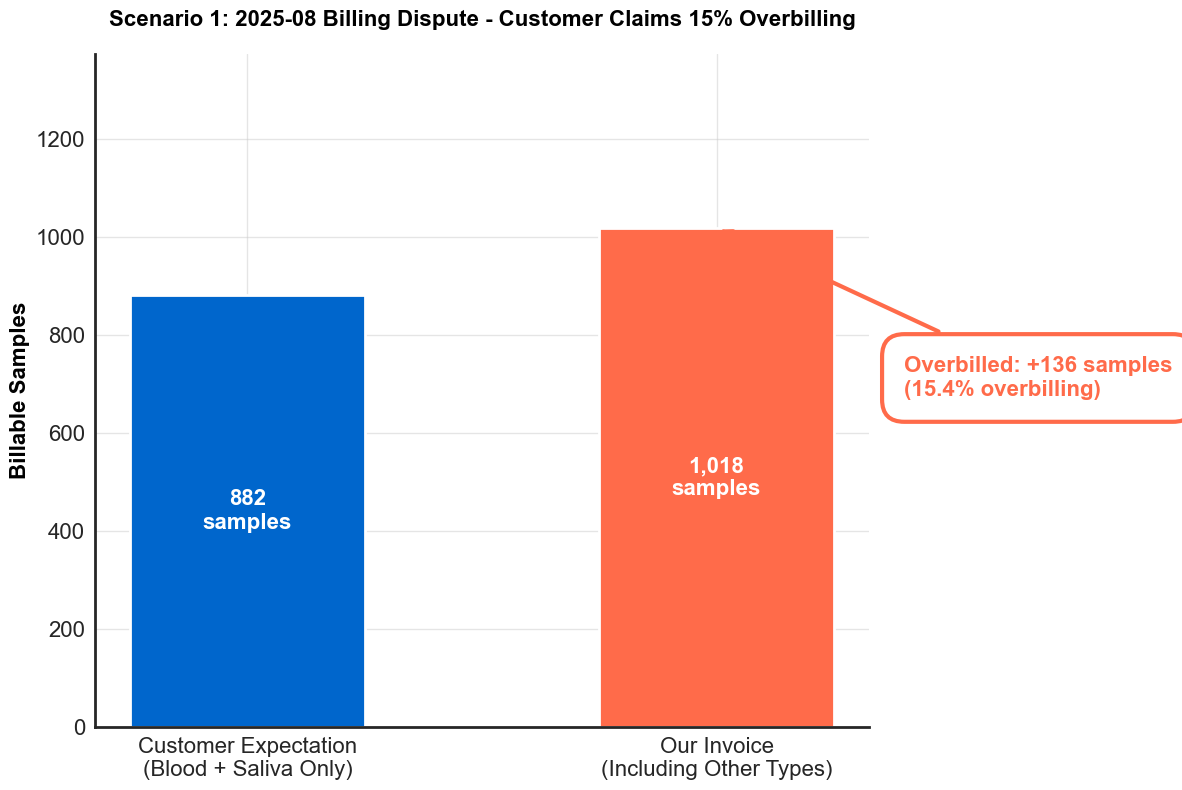

In [7]:
# Scenario 1 - Visual 1: The Billing Dispute (Executive Summary)
# What we're showing: The core dispute - customer expectation vs actual invoice
# Why: Immediately shows the problem at a glance for stakeholders

visual1_billing_dispute()

## Scenario 1 – Billing Reconciliation: Narrative

- **Billing logic used**  
  - Only workflows classified as `ENVIRONMENT = 'live'` (production) are included.  
  - Only runs with `OUTCOME = 'finished'` are treated as successfully processed.  
  - At sample level, only QC checks with `QC_CHECK = 'pass'` or no QC result (`NaN`) are considered **billable**.

- **What the customer expects vs what actually happened**  
  - The customer states that only **blood** and **saliva** samples should be billed.  
  - In reality, within live, finished, billable runs we see **three main sample types** being billed: blood, saliva and **bone marrow**, plus a handful of `NaN` sample types.

- **All‑time view (live, finished, billable)**  
  - Total billable samples: **3,608**.  
  - Blood + saliva: **3,139** samples.  
  - Other types (almost entirely **bone marrow**, plus 1 `NaN`): **469** samples.  
  - These non‑blood/saliva samples account for **~14.9% extra volume** over and above the blood+saliva samples.

- **Month‑by‑month view (live, finished, billable)**  
  - 2025‑05: 627 billable samples, 58 non‑blood/saliva (**10.2%** of blood+saliva).  
  - 2025‑06: 707 billable samples, 84 non‑blood/saliva (**13.5%**).  
  - 2025‑07: 1,255 billable samples, 191 non‑blood/saliva (**18.0%**).  
  - 2025‑08: 1,019 billable samples, 136 non‑blood/saliva (**15.4%**).  
  - The disputed month (latest, 2025‑08) shows **~15%** of billable volume coming from non‑blood/saliva samples, which matches the customer’s **15% over‑billing** claim.

- **Root cause explanation**  
  - Several **[LIVE] Pre‑PCR DNA Extraction** workflows are being used to process **bone marrow** as well as blood/saliva.  
  - The billing logic does not restrict to blood/saliva at sample level, so **all live samples that pass QC (including bone marrow) are billed**.  
  - As a result, bone‑marrow samples and a few `NaN` sample types are included on the invoice, even though the customer only expects blood and saliva to be billed.

- **Recommendation**  
  - Update billing rules to only count samples where `SAMPLE_TYPE ∈ {blood, saliva}` for production invoices.  
  - Optionally, separate live workflows (or add metadata/flags) for bone marrow vs blood/saliva to avoid ambiguity.  
  - Review past invoices for May–August to quantify and correct the over‑billing caused by bone‑marrow samples being included.


VERIFYING MONTHLY DATA - MUST SHOW ALL MONTHS
Monthly dataframe shape: (4, 4)
Number of months: 4
Months present: [Period('2025-05', 'M'), Period('2025-06', 'M'), Period('2025-07', 'M'), Period('2025-08', 'M')]

Monthly dataframe (ALL MONTHS):


,TOTAL_SAMPLES,BLOOD_SALIVA,OTHER_TYPES,OVERBILLING_PCT
YEAR_MONTH,,,,
2025-05,627,569,58,10.19
2025-06,707,623,84,13.48
2025-07,1255,1064,191,17.95
2025-08,1018,882,136,15.42



✅ Monthly dataframe has 4 months - will show all months in visual

Creating visual with ALL months from monthly dataframe...
[OK] Plotting 4 months: 2025-05, 2025-06, 2025-07, 2025-08


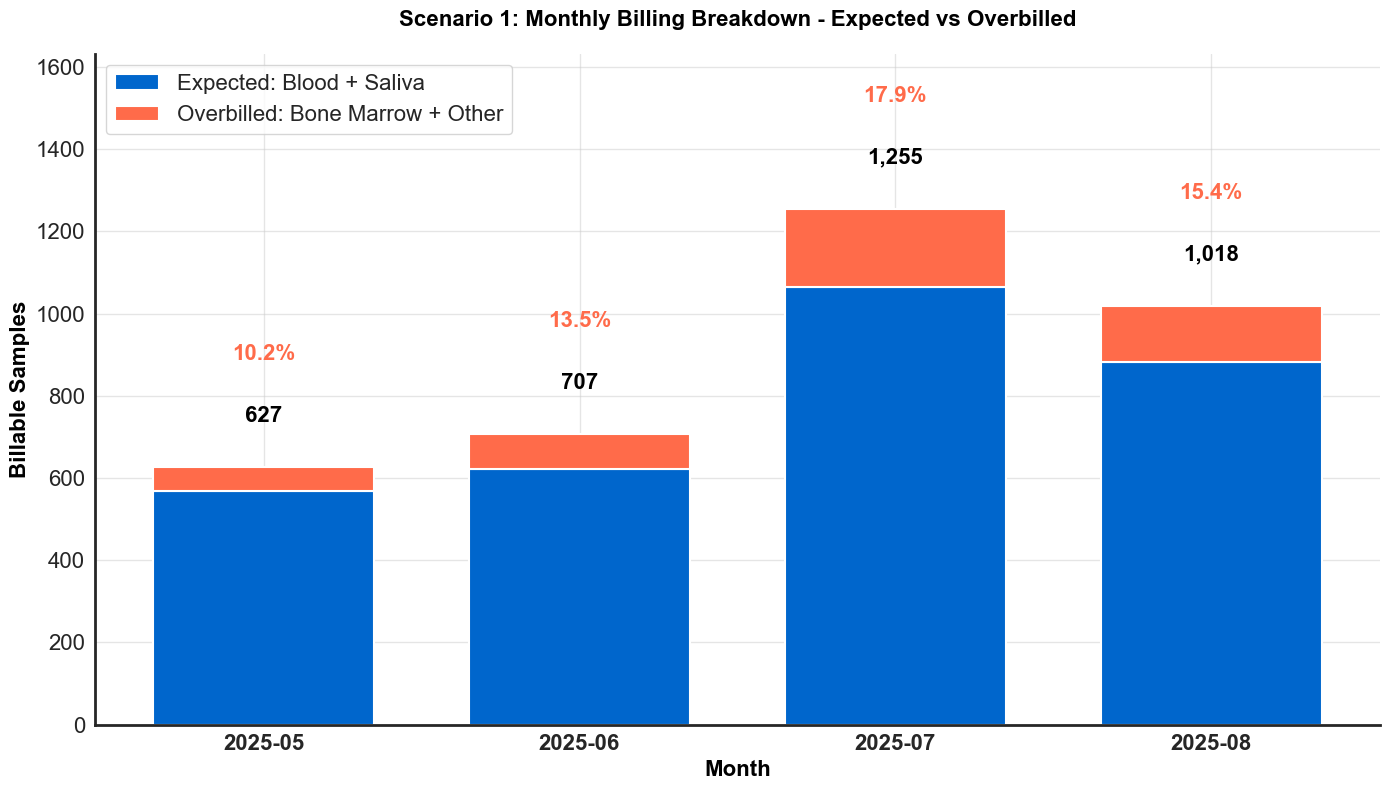

In [8]:
# Scenario 1 - Visual 2: Monthly Billing Trend

# What we're showing: Expected vs actual billing breakdown over time
# Why: Demonstrates the issue is systemic, not isolated to one month

# CRITICAL: This visual must show ALL months, not just one month

if 'monthly' not in locals() or monthly.empty:
    print("ERROR: Run previous cells first to create monthly dataframe.")
else:
    # Verify we have all months before creating visual
    print("=" * 80)
    print("VERIFYING MONTHLY DATA - MUST SHOW ALL MONTHS")
    print("=" * 80)
    print(f"Monthly dataframe shape: {monthly.shape}")
    print(f"Number of months: {len(monthly)}")
    print(f"Months present: {monthly.index.tolist()}")
    print("\nMonthly dataframe (ALL MONTHS):")
    display(monthly)

    # Ensure monthly is NOT filtered - use ALL months
    if len(monthly) < 2:
        print(f"\n⚠️  WARNING: Only {len(monthly)} month(s) in monthly dataframe!")
        print("This might indicate:")
        print("  1. billable_live only has data from one month")
        print("  2. Data filtering is happening somewhere")
        if 'billable_live' in locals() and not billable_live.empty:
            print(f"\nChecking billable_live date range:")
            print(f"  Min date: {billable_live['WORKFLOW_TIMESTAMP'].min()}")
            print(f"  Max date: {billable_live['WORKFLOW_TIMESTAMP'].max()}")
            unique_months = billable_live['YEAR_MONTH'].unique() if 'YEAR_MONTH' in billable_live.columns else 'N/A'
            print(f"  Unique months in billable_live: {unique_months}")
    else:
        print(f"\n✅ Monthly dataframe has {len(monthly)} months - will show all months in visual")

    print("\n" + "=" * 80)
    print("Creating visual with ALL months from monthly dataframe...")
    print("=" * 80)

    # CRITICAL: Pass the FULL monthly dataframe (all months) to visual
    # DO NOT filter or select only one month
    visual2_monthly_trend()

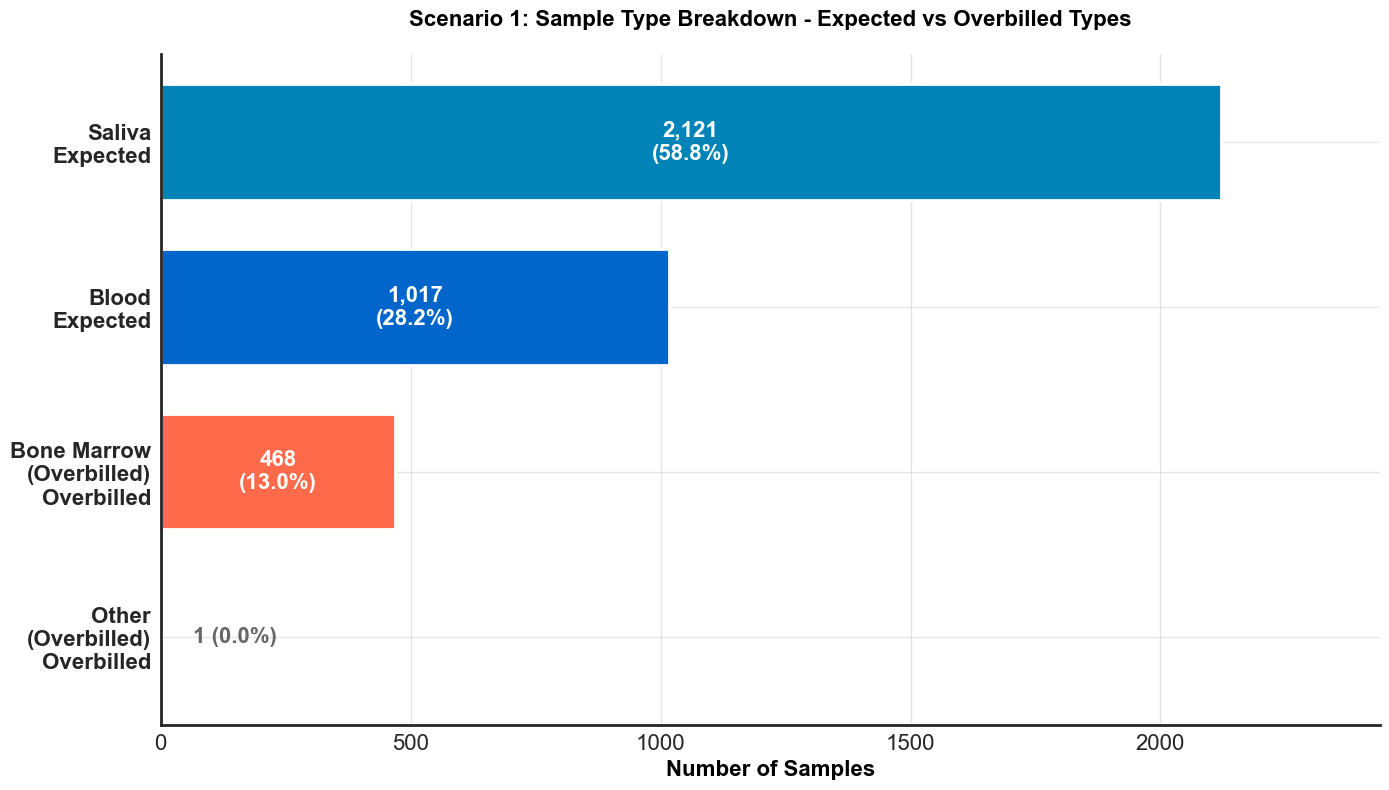

In [9]:
# Scenario 1 - Visual 3: Sample Type Breakdown
# What we're showing: What types of samples are being billed (expected vs overbilled)
# Why: Clearly separates expected (blood/saliva) from overbilled (bone marrow/other)

visual3_sample_types()

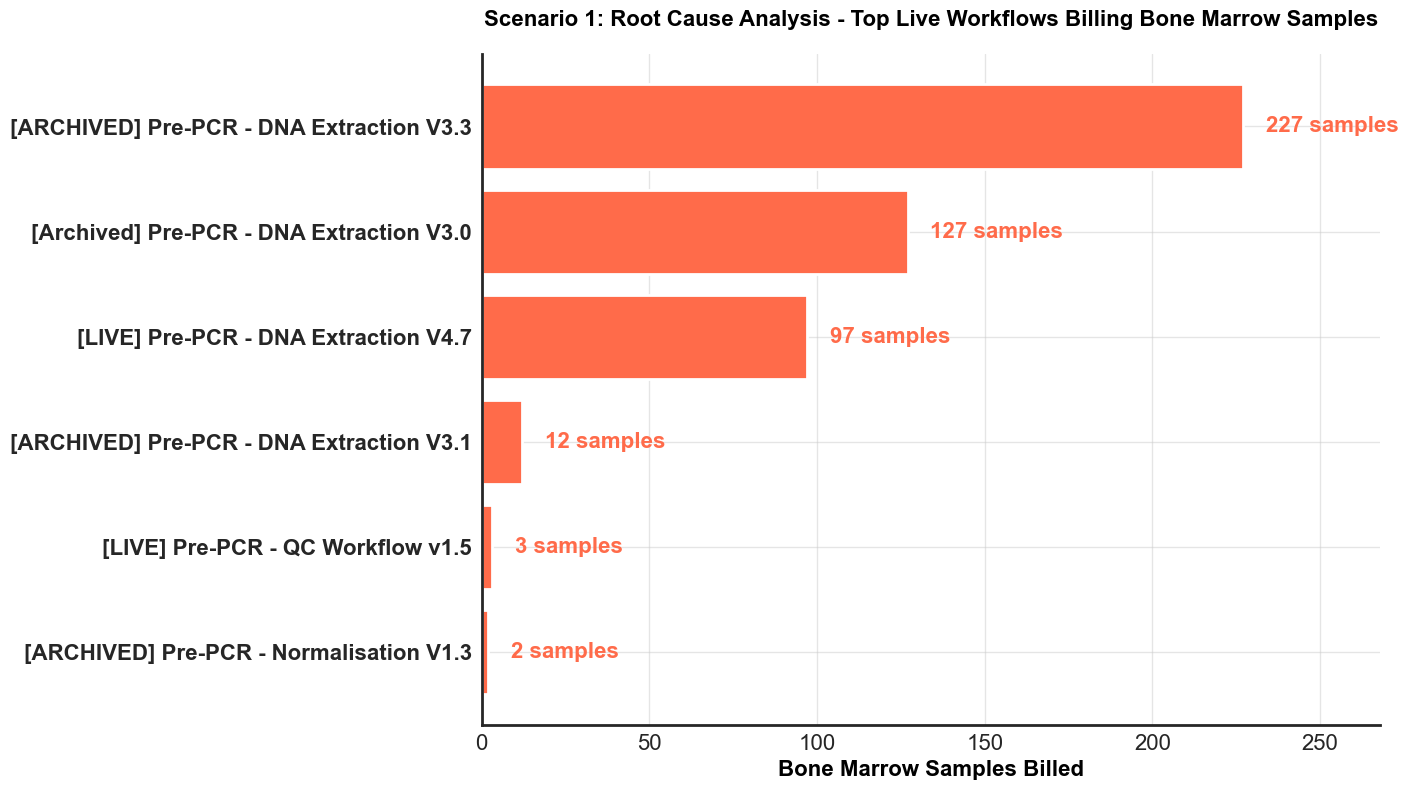

In [10]:
# Scenario 1 - Visual 4: Root Cause Analysis
# What we're showing: Which specific workflows are causing the overbilling problem
# Why: Provides actionable information (which workflows to fix) and shows concentration of the problem

visual4_root_cause()

## Scenario 1 - Time-Based Trend Analysis

**What we're analyzing:** WHEN different sample types are being processed

**Why:** To understand patterns and explain what happened with data-driven insights

**Key Questions:**
- Are blood/saliva and bone marrow processed at different times of day?
- Are different sample types processed on different days of week?
- How has bone marrow processing changed over time?



In [11]:
# Scenario 1 - Time-Based Trend Analysis Summary
# What we're analyzing: WHEN different sample types are being processed
# Why: To understand patterns and explain what happened with data

print("=" * 80)
print("TIME-BASED ANALYSIS: When Are Different Sample Types Processed?")
print("=" * 80)

    # Summary statistics by sample type
sample_type_counts = billable_live["SAMPLE_TYPE"].value_counts(dropna=False)
print("\nSample types in finished LIVE runs:")
print(sample_type_counts)

# Time patterns
billable_live["HOUR"] = billable_live["TIMESTAMP"].dt.hour
billable_live["DAY_OF_WEEK"] = billable_live["TIMESTAMP"].dt.day_name()

print("\nProcessing patterns by time of day (top hours for each type):")
for sample_type in ["blood", "saliva", "bone marrow"]:
    type_data = billable_live[billable_live["SAMPLE_TYPE"] == sample_type]
    if not type_data.empty:
        top_hours = type_data["HOUR"].value_counts().head(3)
        print(f"  {sample_type}: Peak hours {dict(top_hours)}")

print("\nProcessing patterns by day of week:")
day_counts = billable_live["DAY_OF_WEEK"].value_counts()
print(day_counts)



TIME-BASED ANALYSIS: When Are Different Sample Types Processed?

Sample types in finished LIVE runs:
SAMPLE_TYPE
saliva         2121
blood          1017
bone marrow     468
NaN               1
Name: count, dtype: int64

Processing patterns by time of day (top hours for each type):
  blood: Peak hours {12: np.int64(416), 11: np.int64(220), 10: np.int64(155)}
  saliva: Peak hours {10: np.int64(744), 11: np.int64(572), 9: np.int64(428)}
  bone marrow: Peak hours {12: np.int64(177), 10: np.int64(91), 11: np.int64(91)}

Processing patterns by day of week:
DAY_OF_WEEK
Monday       907
Tuesday      851
Friday       791
Thursday     587
Wednesday    437
Saturday      34
Name: count, dtype: int64


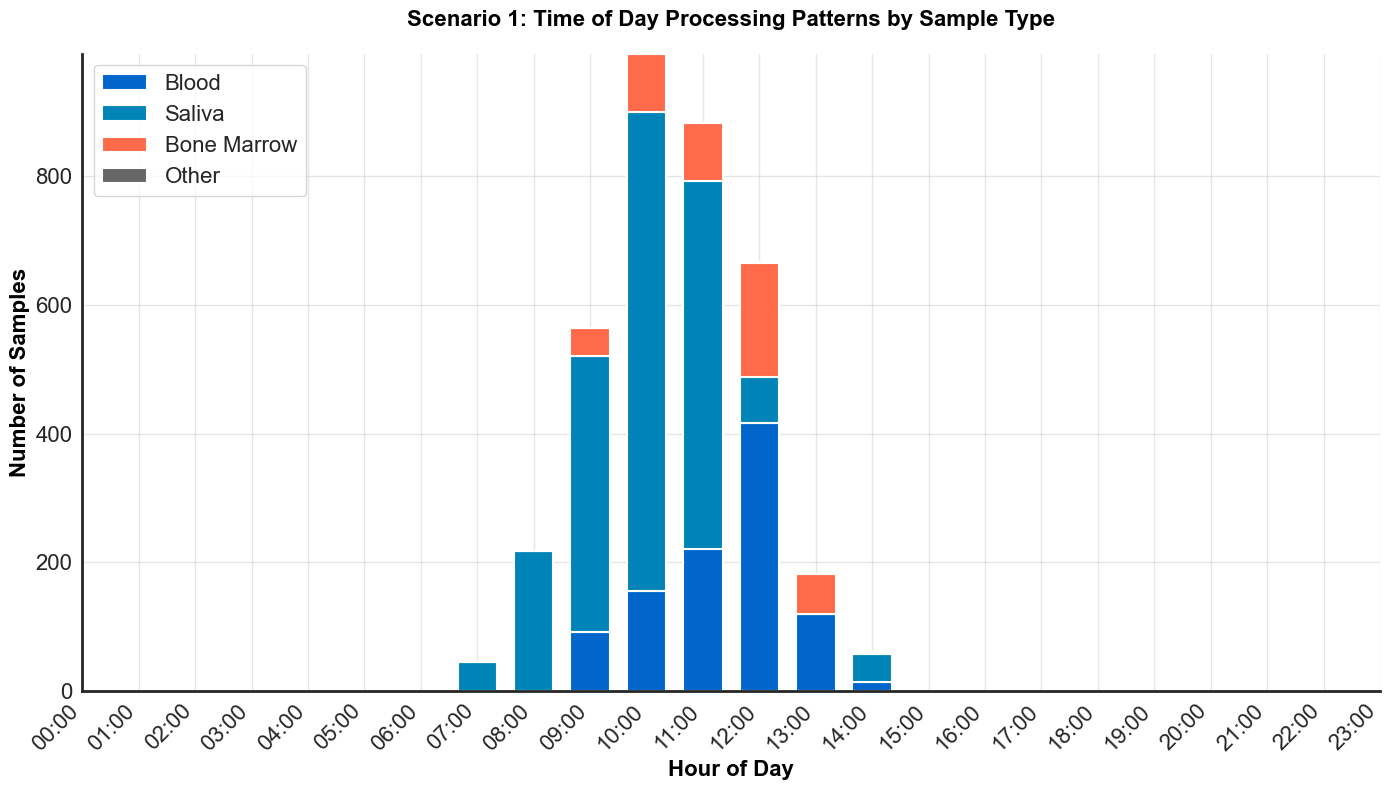

In [12]:
# Scenario 1 - Visual 5: Time of Day Patterns by Sample Type
# What we're showing: Hourly processing patterns for blood, saliva, and bone marrow
# Why: Reveals if different sample types are processed at specific times of day

visual5_time_of_day_patterns()

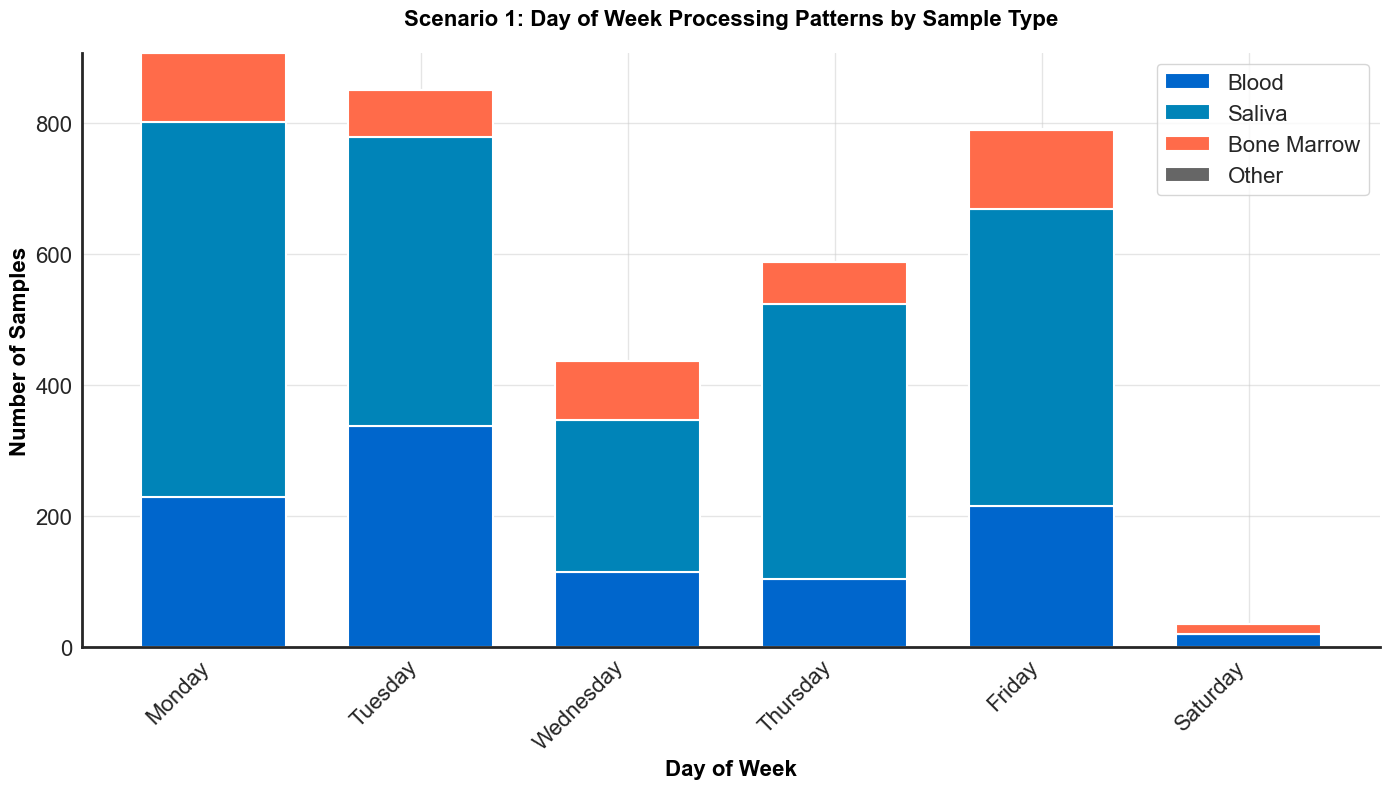

In [13]:
# Scenario 1 - Visual 6: Day of Week Patterns by Sample Type
# What we're showing: Weekly processing patterns for different sample types
# Why: Identifies if bone marrow samples run on specific days vs blood/saliva

visual6_day_of_week_patterns()

## Scenario 1 - Deep Investigation: Why is Bone Marrow in LIVE Workflows?

**Critical Question:** The customer claims they only process blood and saliva in production, but we're seeing bone marrow samples in LIVE workflows. Why?

**Investigation Approach:**
- Which specific workflows are processing bone marrow?
- Are these workflows misconfigured or misclassified?
- When did bone marrow processing start?
- Are there patterns that explain this discrepancy?



In [14]:
# Scenario 1 - Deep Investigation: Bone Marrow in LIVE Workflows# What we're doing: Investigating WHY bone marrow samples are in LIVE workflows# Why: Customer claims they only process blood/saliva, but data shows bone marrow# NOTE: Uses get_billable_live_samples() internally to ensure consistent criteriaprint("=" * 80)print("DEEP INVESTIGATION: Why is Bone Marrow in LIVE Workflows?")print("=" * 80)# Ensure required dataframes existif 'df_checks' not in locals() or 'df_runs' not in locals() or 'df_wfs' not in locals():    print("Run data loading and preparation cells first.")else:    # Run deep investigation    # NOTE: Function uses get_billable_live_samples() internally and filters by sample type    investigation_results = investigate_bone_marrow_in_live(df_checks, df_runs, df_wfs)        if 'error' not in investigation_results:        print(f"\nTotal bone marrow samples in LIVE: {investigation_results['total_bm_samples']}")        print(f"Number of workflows processing bone marrow: {investigation_results['unique_workflows_with_bm']}")                print("\n" + "-" * 80)        print("TOP WORKFLOWS PROCESSING BONE MARROW:")        print("-" * 80)        top_workflows = investigation_results['workflows_processing_bm'].head(10)        for idx, row in top_workflows.iterrows():            # idx is the WORKFLOW_NAME since it's set as index            workflow_name = idx if 'WORKFLOW_NAME' not in row else row['WORKFLOW_NAME']            print(f"\n{workflow_name}")            print(f"  Bone Marrow Samples: {int(row['BONE_MARROW_COUNT'])}")            print(f"  Workflow Type: {row.get('WORKFLOW_TYPE', 'N/A')}")            print(f"  First BM Date: {row.get('FIRST_BM_DATE', 'N/A')}")            print(f"  Last BM Date: {row.get('LAST_BM_DATE', 'N/A')}")                print("\n" + "-" * 80)        print("WORKFLOW NAMING PATTERNS:")        print("-" * 80)        patterns = investigation_results.get('bm_workflow_name_patterns', {})        for pattern, count in patterns.items():            print(f"  Contains '{pattern.replace('_', ' ')}': {count} workflows")                print("\n" + "-" * 80)        print("KEY FINDINGS:")        print("-" * 80)        print("1. Bone marrow IS being processed in LIVE workflows")        print("2. This is not a data classification error")        print("3. Need to investigate: Are these workflows supposed to be LIVE?")        print("4. Question: Did customer configure these workflows, or is this a system default?")    else:        print(investigation_results['error'])

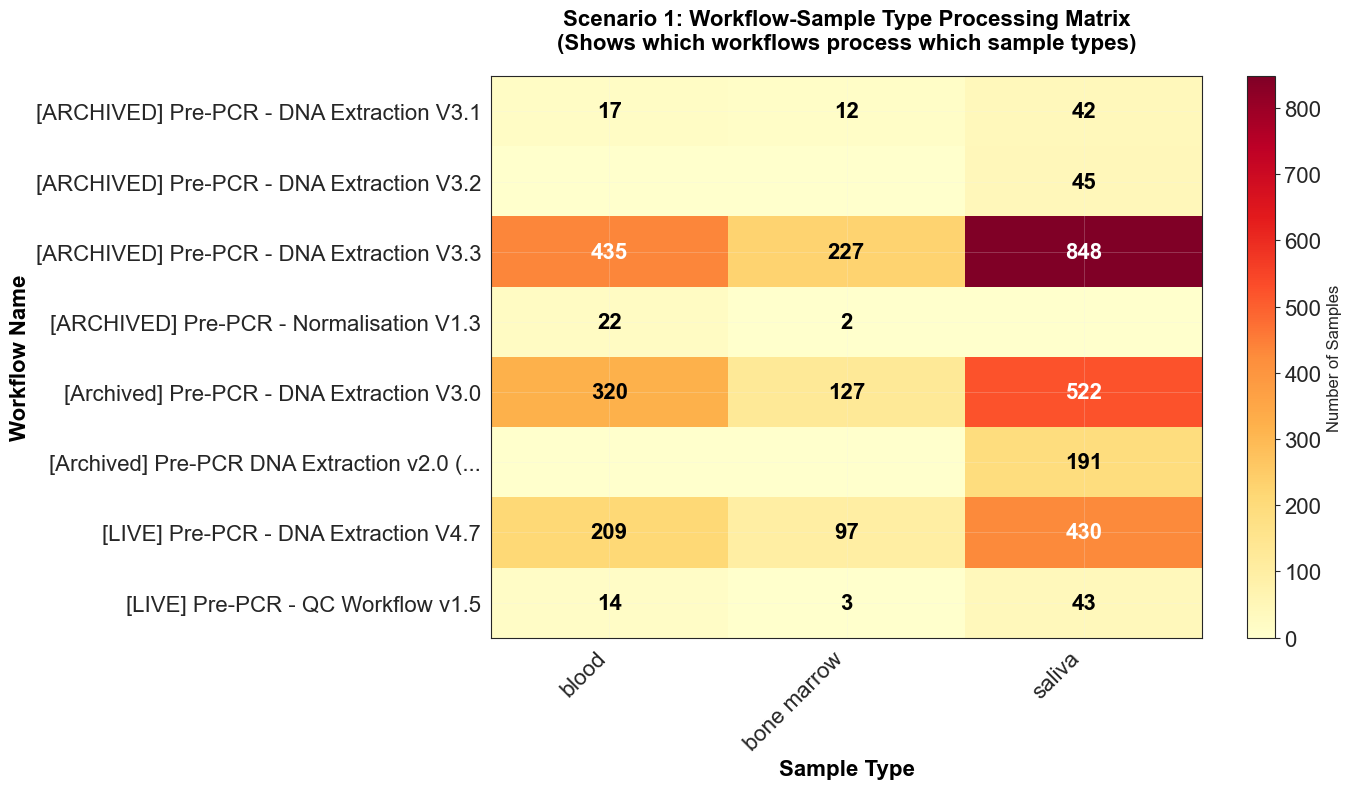

In [15]:
# Scenario 1 - Visual 9: Workflow-Sample Type Matrix
# What we're showing: Which workflows process which sample types
# Why: Reveals patterns and helps identify if workflows are misconfigured

visual9_workflow_sample_type_matrix()



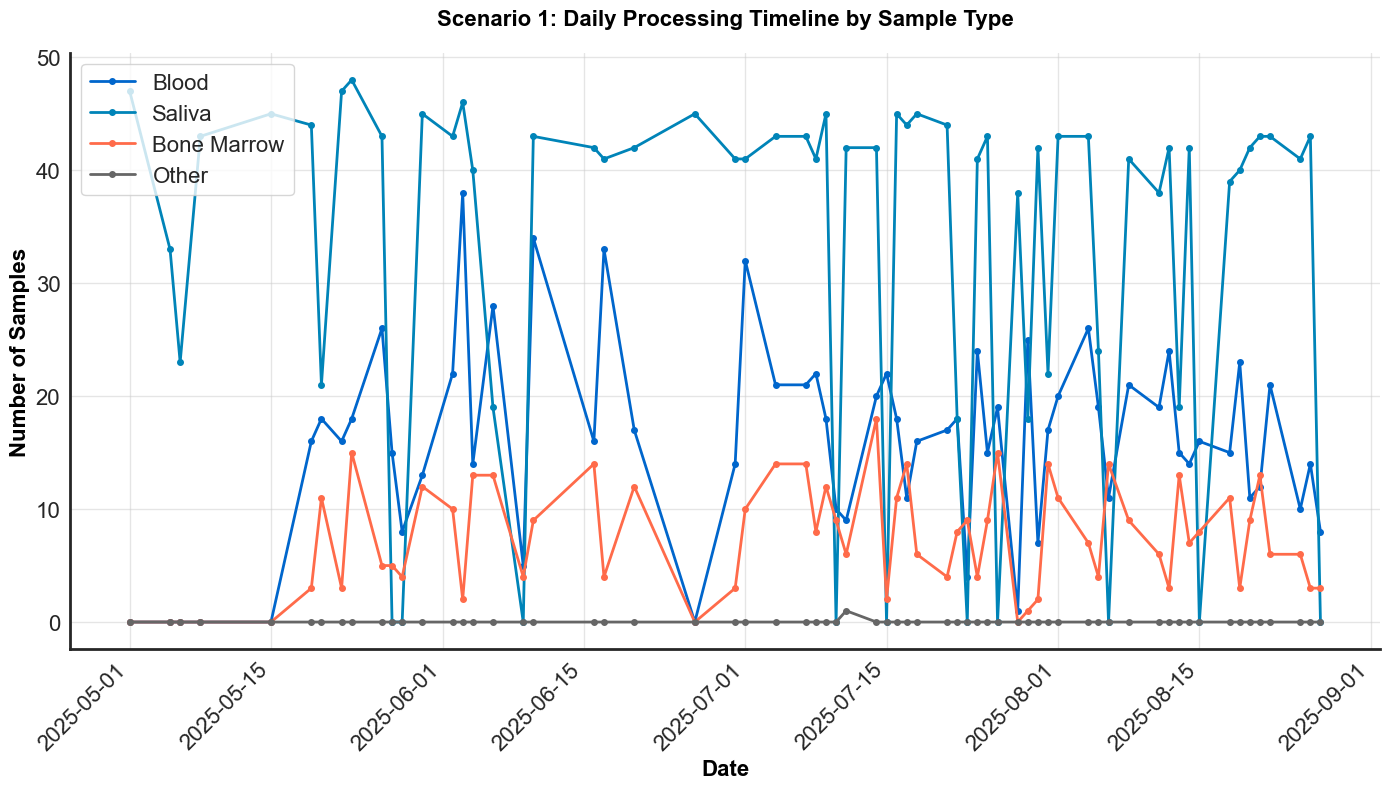

In [16]:
# Scenario 1 - Visual 7: Sample Type Timeline Over Time
# What we're showing: Daily timeline showing when each sample type is processed
# Why: Reveals if bone marrow processing is increasing/decreasing over time

visual7_sample_type_timeline()



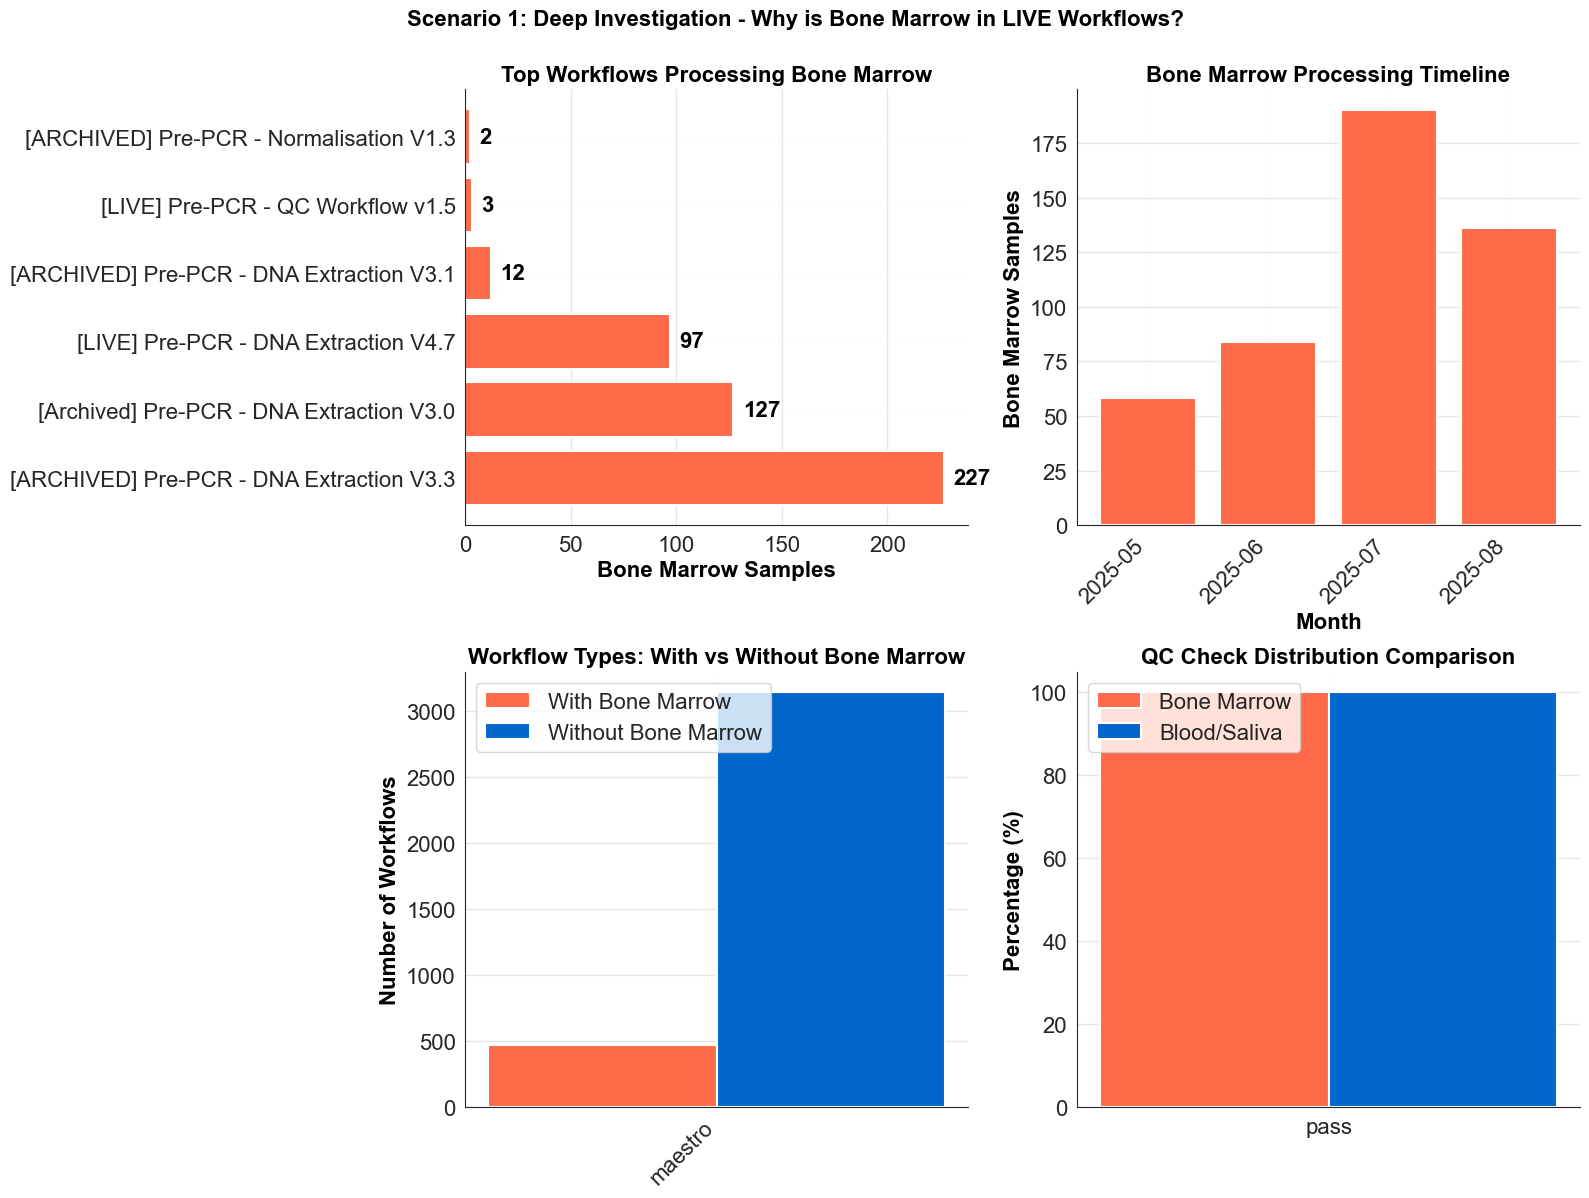

In [17]:
visual8_bone_marrow_workflow_investigation()

## Scenario 1 - Environment Mismatch: LIVE Runs vs ARCHIVED Workflows

**New deep-dive question:** Why do we see some samples where the **run environment is `live`** but the corresponding **workflow environment is `archived`**?

**What we want to verify with data:**
- For **bone marrow** samples, how often do we see `ENVIRONMENT_runs = "live"` but `ENVIRONMENT_wfs = "archived"`?
- Is this pattern different for **blood/saliva** vs **bone marrow**?
- Does the timing suggest that workflows were **used in LIVE originally and only later archived/renamed**?

Below we quantify the environment combinations and highlight how this explains the apparent mismatch between LIVE runs and archived workflows.


In [18]:
# Environment mismatch analysis: LIVE runs vs ARCHIVED workflows

print("=" * 80)
print("ENVIRONMENT MISMATCH ANALYSIS")
print("=" * 80)

# We use the canonical billable dataset to stay consistent with billing logic
billable_live = get_billable_data()

# Sanity check: required environment columns
required_cols = {"ENVIRONMENT_runs", "ENVIRONMENT_wfs", "SAMPLE_TYPE", "RUN_ID"}
missing_cols = required_cols - set(billable_live.columns)
if missing_cols:
    print(f"Missing expected columns in billable_live: {missing_cols}")
else:
    # 1. Overall environment cross-tab for all billable samples
    env_all = (
        billable_live
        .groupby(["ENVIRONMENT_runs", "ENVIRONMENT_wfs"])
        .agg(COUNT=("RUN_ID", "count"))
        .reset_index()
        .sort_values("COUNT", ascending=False)
    )

    print("\nAll billable samples - environment combinations:")
    display(env_all)

    # 2. Focus on bone marrow samples only
    bm = billable_live[billable_live["SAMPLE_TYPE"] == "bone marrow"].copy()
    env_bm = (
        bm
        .groupby(["ENVIRONMENT_runs", "ENVIRONMENT_wfs"])
        .agg(COUNT=("RUN_ID", "count"))
        .reset_index()
        .sort_values("COUNT", ascending=False)
    )

    print("\nBone marrow billable samples - environment combinations:")
    display(env_bm)

    # 3. Compare with blood + saliva for context
    bs = billable_live[billable_live["SAMPLE_TYPE"].isin(["blood", "saliva"])].copy()
    env_bs = (
        bs
        .groupby(["ENVIRONMENT_runs", "ENVIRONMENT_wfs"])
        .agg(COUNT=("RUN_ID", "count"))
        .reset_index()
        .sort_values("COUNT", ascending=False)
    )

    print("\nBlood + saliva billable samples - environment combinations:")
    display(env_bs)

    # 4. Zoom in specifically on the mismatch of interest
    bm_live_archived = bm[
        (bm["ENVIRONMENT_runs"] == "live")
        & (bm["ENVIRONMENT_wfs"] == "archived")
    ]

    print("\nBone marrow where run is LIVE but workflow is ARCHIVED:")
    print(f"  Count: {len(bm_live_archived):,} samples")

    if not bm_live_archived.empty:
        # Identify distinct workflows involved
        bm_live_archived_wfs = bm_live_archived["WORKFLOW_NAME_wfs"].value_counts()
        print("\n  Top workflows with LIVE runs but ARCHIVED workflow metadata:")
        display(bm_live_archived_wfs.head(10))

        # Timing context: when runs happened vs when workflows were created
        merged_bm = bm_live_archived.merge(
            df_wfs[["WORKFLOW_ID", "WORKFLOW_NAME", "WORKFLOW_TIMESTAMP", "ENVIRONMENT_wfs"]],
            on="WORKFLOW_ID",
            how="left",
            suffixes=("_run", "_wfs")
        )

        first_run = merged_bm["START_TIME"].min() if "START_TIME" in merged_bm.columns else None
        last_run = merged_bm["START_TIME"].max() if "START_TIME" in merged_bm.columns else None

        # Handle possible suffixes on WORKFLOW_TIMESTAMP after merge
        if "WORKFLOW_TIMESTAMP" in merged_bm.columns:
            first_wf_ts = merged_bm["WORKFLOW_TIMESTAMP"].min()
            last_wf_ts = merged_bm["WORKFLOW_TIMESTAMP"].max()
        elif "WORKFLOW_TIMESTAMP_wfs" in merged_bm.columns:
            first_wf_ts = merged_bm["WORKFLOW_TIMESTAMP_wfs"].min()
            last_wf_ts = merged_bm["WORKFLOW_TIMESTAMP_wfs"].max()
        else:
            first_wf_ts = None
            last_wf_ts = None

        print("\nTiming context for LIVE runs with ARCHIVED workflows:")
        print(f"  First bone marrow LIVE run: {first_run}")
        print(f"  Last bone marrow LIVE run:  {last_run}")
        print(f"  Workflow creation timestamps for these workflows: {first_wf_ts} to {last_wf_ts}")

        print("\nInterpretation:")
        print("  - `ENVIRONMENT_runs` reflects the workflow name/environment at the time the run executed.")
        print("  - `ENVIRONMENT_wfs` reflects the *current* workflow name (some now tagged as 'archived').")
        print("  - Seeing LIVE runs against workflows that are now ARCHIVED suggests those workflows were")
        print("    used in production first and only later renamed/archived.")
        print("  - This explains why bone marrow appears in LIVE runs even though the workflow metadata")
        print("    now shows an archived environment.")


ENVIRONMENT MISMATCH ANALYSIS

All billable samples - environment combinations:


,ENVIRONMENT_runs,ENVIRONMENT_wfs,COUNT
0,live,archived,2811
1,live,live,796



Bone marrow billable samples - environment combinations:


,ENVIRONMENT_runs,ENVIRONMENT_wfs,COUNT
0,live,archived,368
1,live,live,100



Blood + saliva billable samples - environment combinations:


,ENVIRONMENT_runs,ENVIRONMENT_wfs,COUNT
0,live,archived,2442
1,live,live,696



Bone marrow where run is LIVE but workflow is ARCHIVED:
  Count: 368 samples

  Top workflows with LIVE runs but ARCHIVED workflow metadata:


WORKFLOW_NAME_wfs
[ARCHIVED] Pre-PCR - DNA Extraction V3.3    227
[Archived] Pre-PCR - DNA Extraction V3.0    127
[ARCHIVED] Pre-PCR - DNA Extraction V3.1     12
[ARCHIVED] Pre-PCR - Normalisation V1.3       2
Name: count, dtype: int64


Timing context for LIVE runs with ARCHIVED workflows:
  First bone marrow LIVE run: 2025-05-19 08:22:02.407000
  Last bone marrow LIVE run:  2025-08-06 09:26:46.007000
  Workflow creation timestamps for these workflows: 2025-06-18 21:19:11.079000 to 2025-08-06 17:01:45.673000

Interpretation:
  - `ENVIRONMENT_runs` reflects the workflow name/environment at the time the run executed.
  - `ENVIRONMENT_wfs` reflects the *current* workflow name (some now tagged as 'archived').
  - Seeing LIVE runs against workflows that are now ARCHIVED suggests those workflows were
    used in production first and only later renamed/archived.
  - This explains why bone marrow appears in LIVE runs even though the workflow metadata
    now shows an archived environment.


## Scenario 1 - Bone Marrow Across Environments

**Question:** Is bone marrow mainly a production (LIVE) phenomenon, or do we also see it in non-LIVE environments (test/uat/archived)?

**What this cell will show:**
- Distribution of **all bone marrow samples** (not just billable) by `ENVIRONMENT_runs` and `ENVIRONMENT_wfs`.
- Quick comparison vs blood + saliva so you can say whether bone marrow is disproportionately in LIVE.

This helps you answer: *"Is bone marrow really a production behaviour, or mostly test / archived noise?"*


In [19]:
# Bone marrow across environments (all runs, not just billable)

print("=" * 80)
print("BONE MARROW ACROSS ENVIRONMENTS (ALL RUNS)")
print("=" * 80)

# Use the fully merged dataframe so we see all runs, not only billable
try:
    df  # check if df exists from earlier cells
except NameError:
    df = final_merge()

required_cols_full = {"SAMPLE_TYPE", "ENVIRONMENT_runs", "ENVIRONMENT_wfs"}
missing_full = required_cols_full - set(df.columns)
if missing_full:
    print(f"Missing expected columns in merged df: {missing_full}")
else:
    # 1. Bone marrow distribution by run and workflow environments
    df_bm_all = df[df["SAMPLE_TYPE"] == "bone marrow"].copy()

    bm_env = (
        df_bm_all
        .groupby(["ENVIRONMENT_runs", "ENVIRONMENT_wfs"])
        .size()
        .rename("BONE_MARROW_SAMPLES")
        .reset_index()
        .sort_values("BONE_MARROW_SAMPLES", ascending=False)
    )

    print("\nBone marrow samples by run/workflow environment (all runs):")
    display(bm_env)

    # 2. Context: blood + saliva distribution across environments
    df_bs_all = df[df["SAMPLE_TYPE"].isin(["blood", "saliva"])].copy()

    bs_env = (
        df_bs_all
        .groupby(["ENVIRONMENT_runs", "ENVIRONMENT_wfs"])
        .size()
        .rename("BLOOD_SALIVA_SAMPLES")
        .reset_index()
        .sort_values("BLOOD_SALIVA_SAMPLES", ascending=False)
    )

    print("\nBlood + saliva samples by run/workflow environment (all runs):")
    display(bs_env)

    # 3. High-level takeaway: what share of bone marrow is in LIVE runs?
    bm_live = df_bm_all[df_bm_all["ENVIRONMENT_runs"] == "live"]
    bm_live_count = len(bm_live)
    bm_total = len(df_bm_all)
    share_live = (bm_live_count / bm_total * 100) if bm_total > 0 else 0

    print("\nSummary:")
    print(f"  Total bone marrow samples (all environments): {bm_total:,}")
    print(f"  Bone marrow in LIVE runs: {bm_live_count:,} ({share_live:.1f}% of all bone marrow)")
    print("  This lets you state whether bone marrow is primarily a production behaviour or spread across test/archived.")


BONE MARROW ACROSS ENVIRONMENTS (ALL RUNS)

Bone marrow samples by run/workflow environment (all runs):


,ENVIRONMENT_runs,ENVIRONMENT_wfs,BONE_MARROW_SAMPLES
0,live,archived,529
1,live,live,149



Blood + saliva samples by run/workflow environment (all runs):


,ENVIRONMENT_runs,ENVIRONMENT_wfs,BLOOD_SALIVA_SAMPLES
0,live,archived,3266
1,live,live,913
4,uat,uat,442
3,uat,archived,336
2,test,test,192



Summary:
  Total bone marrow samples (all environments): 678
  Bone marrow in LIVE runs: 678 (100.0% of all bone marrow)
  This lets you state whether bone marrow is primarily a production behaviour or spread across test/archived.
